# Download and Import Data

In [2]:
import requests

postcode_data_url = "http://www.nomisweb.co.uk/output/census/2011/Postcode_Estimates_Table_1.csv"

with requests.Session() as s:
    download = s.get(postcode_data_url)
    decoded_content = download.content.decode('utf-8')

csv_file = open("Postcode_Estimates_Table_1.csv", "w")
csv_file.write(decoded_content)
csv_file.close()



In [1]:
import pandas as pd

#default to .3f for pandas floats
pd.options.display.float_format = '{:.1f}'.format

df_postcodes = pd.read_csv("Postcode_Estimates_Table_1.csv")
df_postcodes

,Postcode,Total,Males,Females,Occupied_Households
0,AL1 1AG,14,6,8,6
1,AL1 1AJ,124,60,64,51
2,AL1 1AR,32,17,15,17
3,AL1 1AS,34,17,17,13
4,AL1 1BH,52,15,37,41
...,...,...,...,...,...
1308775,YO8 9YA,23,14,9,8
1308776,YO8 9YB,33,17,16,13
1308777,YO8 9YD,9,4,5,4
1308778,YO8 9YE,13,6,7,3


# Data Cleaning



## Missing Data and Datatypes

The dataset has no missing values and columns are all of the expected datatypes.

In [2]:
df_postcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308780 entries, 0 to 1308779
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   Postcode             1308780 non-null  object
 1   Total                1308780 non-null  int64 
 2   Males                1308780 non-null  int64 
 3   Females              1308780 non-null  int64 
 4   Occupied_Households  1308780 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 49.9+ MB


## Postcode Format and Part Extraction

UK postcodes can be in inconsistent formats so we should first do some work to check out how they are formatted.

First we want to explore the format of the postcode strings. A good first check is to see if they are all the same length:

In [3]:
df_postcodes["Postcode"].apply(len).value_counts()

7    1308780
Name: Postcode, dtype: int64

They are all of length 7.

Postcodes can be in one of 6 formats:

| ![UK Postcode Formats](images/uk_postcode_format.png) |
|:--:|
| Obtained from https://ideal-postcodes.co.uk/guides/uk-postcode-format |

Inspecting the postcodes in the data, set they are formated as:
 - Fixed length of 7 characters.
 - Outcodes left aligned.
 - Incodes right aligned.
 - Padded with spaces in between the outcodes and incodes where they are not 7 characters long.

We will use regex with capture groups to extract parts of the postcode we are interested in:
- Sector
- Sub District (which we will treat the same as disctrict for those without a sub-district)
- District
- Area

These represent increasingly larger geographical areas (with the smallest being the full postcode) without duplication.

In [4]:
#regex to extract Sector (1), Sub-District (2), District (3) and Area (4)
regex_str = r"^(((([A-Z]{1,2})[0-9]{1,2})[A-Z]?)\s*[0-9])[A-Z]{2}$"
postcode_parts = ["Sector", "Sub-District", "District", "Area"]
df_postcodes[postcode_parts] = df_postcodes["Postcode"].str.extract(regex_str)
#rename columns to be more descriptive
df_postcodes = df_postcodes.rename(columns={"Occupied_Households":"Occupied Households", "Total":"Total Population", "Males":"Male Population", "Females":"Female Population"})
df_postcodes

,Postcode,Total Population,Male Population,Female Population,Occupied Households,Sector,Sub-District,District,Area
0,AL1 1AG,14,6,8,6,AL1 1,AL1,AL1,AL
1,AL1 1AJ,124,60,64,51,AL1 1,AL1,AL1,AL
2,AL1 1AR,32,17,15,17,AL1 1,AL1,AL1,AL
3,AL1 1AS,34,17,17,13,AL1 1,AL1,AL1,AL
4,AL1 1BH,52,15,37,41,AL1 1,AL1,AL1,AL
...,...,...,...,...,...,...,...,...,...
1308775,YO8 9YA,23,14,9,8,YO8 9,YO8,YO8,YO
1308776,YO8 9YB,33,17,16,13,YO8 9,YO8,YO8,YO
1308777,YO8 9YD,9,4,5,4,YO8 9,YO8,YO8,YO
1308778,YO8 9YE,13,6,7,3,YO8 9,YO8,YO8,YO


We should check that we have an expected range of lengths for each part, and that we have no nulls:

In [5]:
for col in postcode_parts:
    print(col)
    print("Nulls: " + str(df_postcodes[col].isnull().sum()))
    print("Length count:")
    print(df_postcodes[col].apply(len).value_counts())
    print()

Sector
Nulls: 0
Length count:
5    1308780
Name: Sector, dtype: int64

Sub-District
Nulls: 0
Length count:
3    644619
4    631294
2     32867
Name: Sub-District, dtype: int64

District
Nulls: 0
Length count:
3    644978
4    627471
2     36331
Name: District, dtype: int64

Area
Nulls: 0
Length count:
2    1162930
1     145850
Name: Area, dtype: int64



This all looks as expected.

## Visualisation

As a last sense check, we can plot the histograms of group sizes for each postcode part.

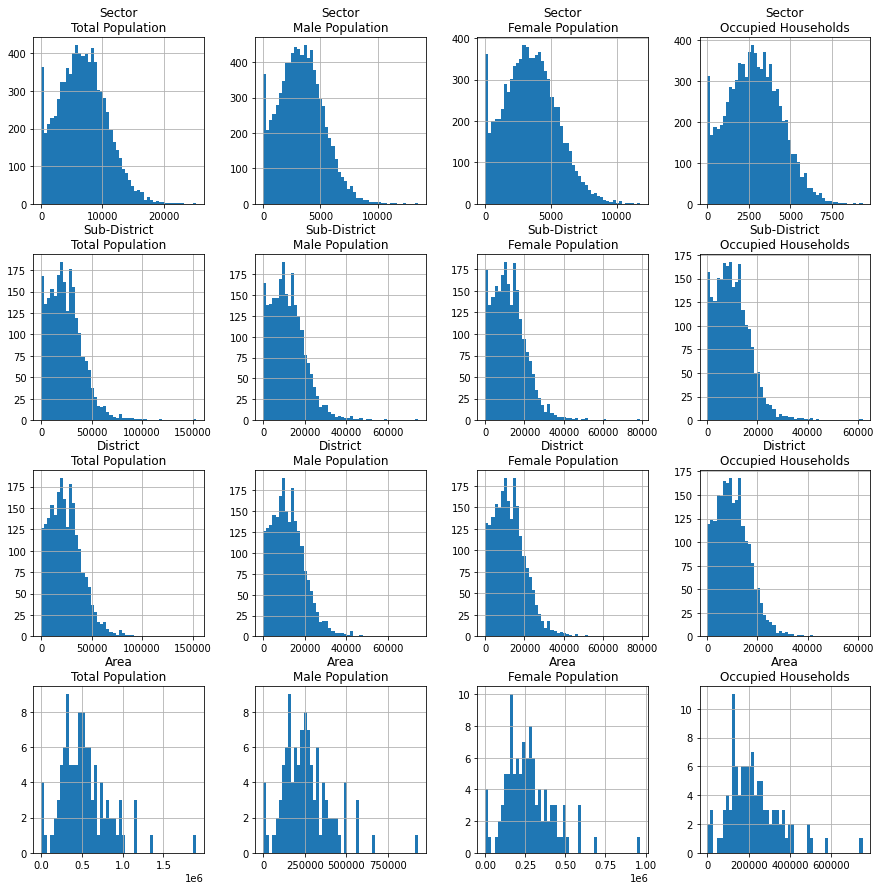

In [6]:
import matplotlib.pyplot as plt

populations = ["Total Population", "Male Population", "Female Population", "Occupied Households"]
fig, axs = plt.subplots(4,4, figsize=(15,15))
plt.subplots_adjust(wspace=0.2,  
                    hspace=0.2)

df_part = {}
for i in range(0,len(postcode_parts)):
    for j in range(0,len(populations)):
        part = postcode_parts[i]
        population = populations[j]
        df_part[part] = df_postcodes.groupby(by=part).sum()
        df_part[part].hist(column=population, layout=(1,4), ax=axs[i,j], bins=50)
        axs[i,j].set_title(f"{part}\n{population}")

Data is right skewed, and there are a disproprionate number of small group sizes (high peaks on the left of the plots). This is the sort of distribution we'd expect from a dataset like this.

# Anonymity Threshold

Given how UK postcodes are constructed, we can't simply truncate postcodes to 3 characters as is done for USA zip codes as this will result in postcode areas being combined together in ways which do not have real geographic meaning. For example, "NE3 1ED" and "NE35 2FG" are both valid postcodes. Truncating both of these to the first 3 characters would put these both in the "NE3" group. They should instead be both in an "NE" area group or seperate "NE3" and "NE35" district groups (or sector or sub-disctrict groups).

As we have seperated each postcode into the corresponding area, district, sub-disctrict and sector codes we can sum the populations of all the groups at these geographic levels. This information can be used to make decisions on what postcode level would be appropriate to use to ensure anonymisation.

Our approach here will be to to select a range of thresholds to test our data against. This threshold is the minimum group size that would be acceptable in an anonymised dataset. Any groups smaller than this size would need to be aggregated into larger ones.

We'll test each of our 4 postcode geographic levels against our threshold ranges, counting the number of groups that are smaller than the selected threshold.


## Selecting Postcode Geographic Level

In [7]:
#generate thresholds
thresholds = (i*10**exp for exp in range(0,7) for i in range(1,9))
threshold_count = []

#test each post code part and count the number of groups smaller than the threshold for each population (Total, Males, Females, Housing)
for threshold in thresholds:
    for part in postcode_parts:
        for population in populations:
            s_count = df_part[part][population][df_part[part][population].sort_values() < threshold]
            threshold_count.append({"part":part, "threshold":threshold, "population":population, "Groups Below Threshold #":s_count.count() , "Groups Below Threshold %":(s_count.count()/df_part[part][population].count())*100})

#store as a dataframe
df_threshold_group_count = pd.DataFrame.from_dict(threshold_count)

#re-arrange the data so that is suitable for plotting
df_threshold_group_count_pivot = df_threshold_group_count.pivot(index=["threshold"], columns=["population", "part"])

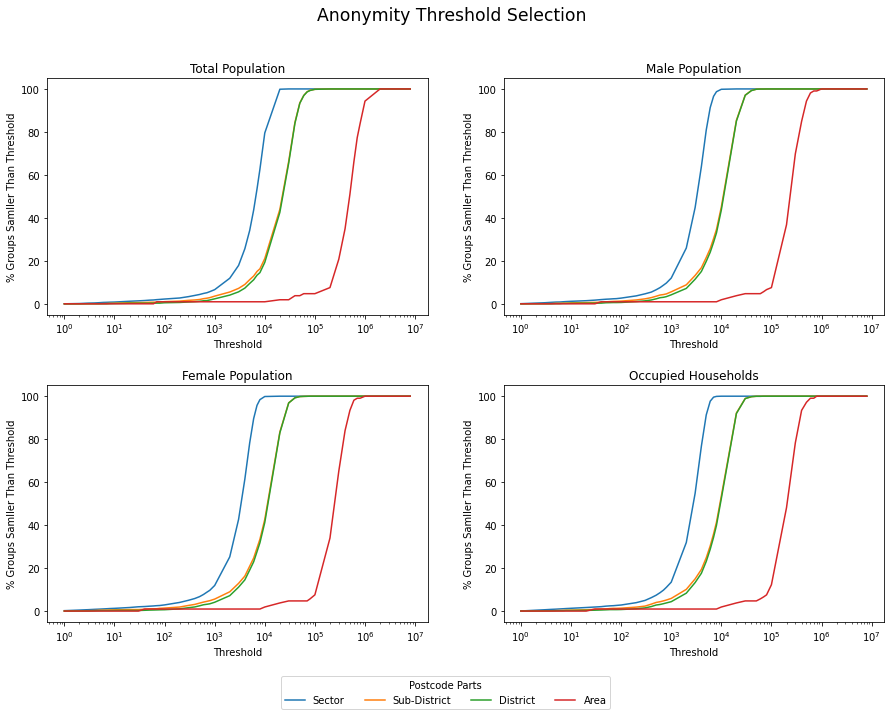

In [17]:
import warnings
# suppress some warnings
# deprecated matplotlib feature built in to pandas, can't do anything about this
warnings.filterwarnings('ignore', module="pandas", lineno=400)
# performance warning, not worried for this
warnings.filterwarnings('ignore', module="IPython", lineno=2894)
# non dangerous warning from fig.legend line
warnings.filterwarnings('ignore', message="You have mixed positional and keyword arguments")

fig, axs = plt.subplots(2,2, figsize=(15,10))
plt.subplots_adjust(wspace=0.2,  
                    hspace=0.3) 


coords = ((0,0),(0,1),(1,0),(1,1))

#for each population, plot the number of groups smaller than the threshold
for i in range (0,4):
    df_threshold_group_count_pivot[("Groups Below Threshold %", populations[i])].plot(legend=False,logx=True, xlabel="Threshold", ylabel=r"% Groups Samller Than Threshold", title=populations[i], ax=axs[coords[i]])

fig.suptitle("Anonymity Threshold Selection", size="xx-large")
fig.legend(axs, title="Postcode Parts", labels=postcode_parts, loc="lower center", ncol=len(postcode_parts)) 
plt.show()

Using the plots:

1 Choose the population of interest.
- For example, the total population (top left graph)

2 Select an anonymity treshold on the x-axis. 
- This threshold should be chosen so that data is considered anonymised if all the geographic postcode groups are larger than the threshold
- i.e. a treshold of 10^5 means that data is considered anonymous if the smallest group size is larger than 100,000.

3 The value of the curve at the chosen threshold tells you what percentage of groups are smaller than this threshold.
- e.g. for a threshold of 10^5, only a small number the groups at the postcode area level (red curve) are smaller than 10,000 total population.
- This would probably be considered anonymous at this level, as the remaining small groups can be aggregated into a single larger one.
- In contrast, at the sector, sub-district of district level, close to 100% of the groups are below this threshold, and the data would be defined as not anonymous.



## Selecting Population

If the postcode geographic level is already chosen, it might be desireable to choose what population level to publish: total population, male & female or households. Using the same data we can arrange the plots to provide a similar utility to the above for this scenario.

In [9]:
df_threshold_group_count_pivot_population = df_threshold_group_count.pivot(index=["threshold"], columns=["part", "population"])

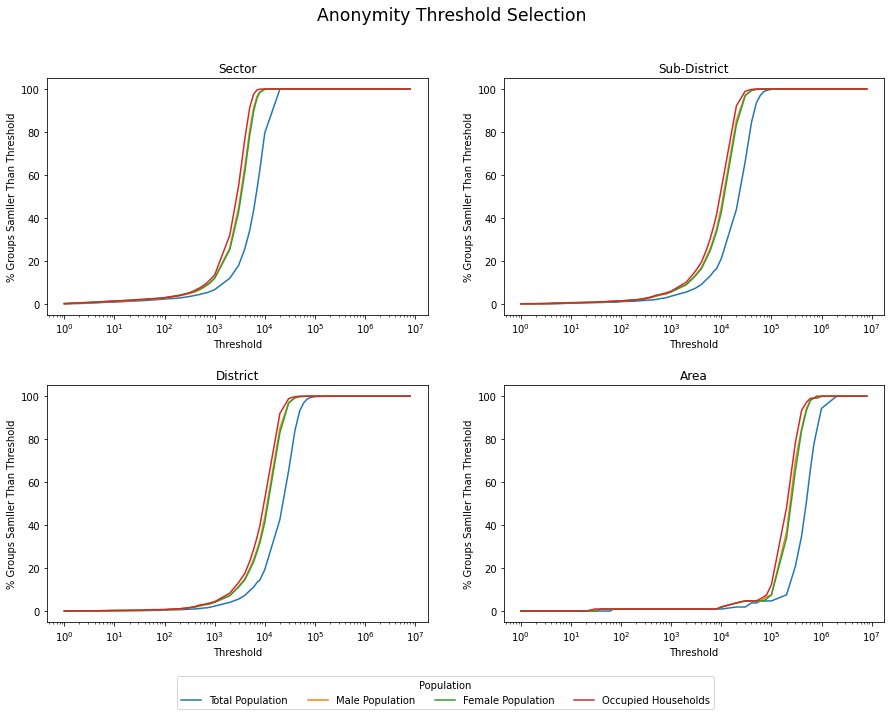

In [19]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
plt.subplots_adjust(wspace=0.2,  
                    hspace=0.3) 

coords = ((0,0),(0,1),(1,0),(1,1))

#for each population, plot the number of groups smaller than the threshold
for i in range (0,4):
    df_threshold_group_count_pivot_population[("Groups Below Threshold %", postcode_parts[i])].plot(legend=False, logx=True, xlabel="Threshold", ylabel=r"% Groups Samller Than Threshold", title=postcode_parts[i], ax=axs[coords[i]])

fig.suptitle("Anonymity Threshold Selection", size="xx-large")
fig.legend(axs, title="Population", labels=populations, loc="lower center", ncol=len(postcode_parts)) 
plt.show()

Using the plots:

1 Choose the postcode geographic level of interest.
- For example, the district (bottom left graph)

2 Select an anonymity treshold on the x-axis. 

3 The value of the curve at the chosen threshold tells us what percentage of groups are smaller than this threshold.
- e.g. for a threshold of 10^4, about 15% of groups a the district level are smaller than 10,000 total population (blue curve) and about 35% of the groups are smaller than the threshold for the remaining population measures



## Lookup Utility

The code below takes in a chosen population, postcode geographic level and anonymity threshold and will output the number of groups smaller than the anonymity threshold, and list them in ascending order.

In [55]:
population = "Total Population"
part = "District"
threshold = 10**3

s_count = df_part[part][population][df_part[part][population].sort_values() < threshold]

small_groups = s_count.count()
total_groups = df_part[part][population].count()

print("There {} {} postcode {}{} of {} ({:.1f}%) with a {} size of less than {:,}.\n".format(
    "is" if small_groups == 1 else "are",
    small_groups, 
    part.lower(),
    "s" if small_groups != 1 else "",
    total_groups,
    (small_groups/total_groups)*100,
    population.lower(),
    threshold
    ))

print("Problem {}s:\n".format(part.lower()))

print(s_count.sort_values().to_frame())

There are 52 postcode districts of 2246 (2.3%) with a total population size of less than 1,000.

Problem districts:

          Total Population
District                  
UB11                     2
DG14                     7
B40                      9
TD5                     10
TW6                     16
M17                     17
DG16                    58
TR23                    84
TR22                    85
M2                      88
PE35                    99
TD9                    105
TR25                   136
TR24                   175
LL73                   233
LL39                   236
LL66                   264
LL70                   269
LL76                   280
CA18                   324
CR9                    339
SA36                   366
NE69                   417
EC3                    421
L29                    435
LL43                   487
LL25                   501
LL78                   502
TA17                   513
LL47                   537
LL37               